https://gymnasium.farama.org/environments/box2d/lunar_lander/

### Ustawienie hardware

In [46]:
import torch

OPTIMIZE_WITH_HARDWARE = True

device = torch.device('cpu')
if OPTIMIZE_WITH_HARDWARE:
    if torch.backends.mps.is_available():
        device = torch.device('mps')
        print(f'Selected device: MPS')
    elif torch.cuda.is_available():
        device = torch.device('cuda')
        print(f'Selected device: GPU with CUDA support')
        print(f'CUDA device name: {torch.cuda.get_device_name()}')
        print(f'CUDA device count: {torch.cuda.device_count()}')
        print(f'CUDA device index: {torch.cuda.current_device()}')
else:
    print(f'Selected device: CPU')
    

Selected device: GPU with CUDA support
CUDA device name: Quadro M1200
CUDA device count: 1
CUDA device index: 0


# Ogólne przedstawienie problemu

In [47]:
import warnings
warnings.filterwarnings("ignore")
import gym 
env = gym.make("LunarLander-v2")

In [48]:
import warnings
warnings.filterwarnings('ignore')

env.reset()

terminated = False
truncated = False 

while not (terminated or truncated):
    action = 1
    obs, reward, terminated, info = env.step(action)
    env.render()
    
env.close()

## Co zwraca środowisko?

Stan - wektor opisujący aktualne położenie i dynamikę lądownika.
- pozycja pozioma lądownika (x);
- pozycja pionowa lądownika (y)
- prędkość pozioma lądownika
- prędkość pionowa lądownika
- kąt nachylenia lądownika
- prędkość kątowa lądownika
- czy noga nr 1 (lewa) lądownika dotyka podłoża
- czy noga nr 2 (prawa) lądownika dotyka podłoża

## Ile akcji może wykonać agent?

In [49]:
print(f'Ilość możliwych akcji: {env.action_space.n}')

Ilość możliwych akcji: 4


1. Brak działania
2. Uruchomiony główny silnik
3. Uruchomiony lewy silnik
4. Uruchomiony peawy silnik

## Hiperparametry

In [50]:
BATCH_SIZE = 64
LEARNING_RATE = 0.0005
GAMMA = 0.99 # Współczynnik dyskontowania przyszłych nagród
EPSILON_START = 1.0 # Początkowa wartość współczynnika eksploracji
EPSILON_MIN = 0.1
EPSILON_DECAY = 0.995 # Współczynnik zmniejszania wartości współczynnika eksploracji
MEMORY_SIZE = 100000 # Maksymalny rozmiar pamięci przechowującej przejścia (stan, akcja, nagroda...)
TRAIN_START = 1000 # Rozpoczęcie uczenia po zebraniu danej liczby doświadczeń
TARGET_UPDATE = 10

## Zaimportowanie niezbędnych bibliotek

In [51]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

## Struktura sieci głębokiej

- Otrzymujemy stan w postaci wektora ośmiu wyżej wymienionych parametrów. Definiujemy 3 liniowe warstwy, tzn. przetwrzające dane liniowo, realizujące sume ważoną.
- Pierwsza warstwa przyjmuje stan w którym znajduje się łazik (state_size), rozszerza na 128 parametrów.
- Druga warstwa przyjmuje 128 parametrów i na wyjściu ma 128 parametrów.
- Trzecia warstwa która będzie podawać wartość Q dla każdej możliwej do podjęcia akcji przyjmuje 128 parametrów i zwraca 4 wyjścia (action_size)

In [52]:
class DQNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, output_size)

    def forward(self, state):
        x = F.leaky_relu(self.fc1(state), negative_slope=0.01)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.01)
        x = self.fc3(x)
        return x

## Definicja agenta sieci DQN

In [53]:
class DQNAgent:
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.epsilon = EPSILON_START
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.model = DQNetwork(input_size, output_size).to(device)
        self.target_model = DQNetwork(input_size, output_size).to(device)
        self.update_target_model()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=LEARNING_RATE)
        self.loss_function = nn.MSELoss()

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.output_size)
        state = torch.FloatTensor(state).to(device).unsqueeze(0)
        with torch.no_grad():
            q_values = self.model(state)
            return torch.argmax(q_values).item()

    def replay(self):
        if len(self.memory) < TRAIN_START:
            return
        batch = random.sample(self.memory, BATCH_SIZE)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

        q_values = self.model(states).gather(1, actions)
        next_q_values = self.target_model(next_states).max(1)[0].detach().unsqueeze(1)
        target_q_values = rewards + (GAMMA * next_q_values * (1 - dones))

        loss = self.loss_function(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > EPSILON_MIN:
            self.epsilon *= EPSILON_DECAY
        else:
            self.epsilon = EPSILON_MIN

## Definicja pętli treningowej modelu

In [54]:
import warnings
warnings.filterwarnings('ignore')

env = gym.make("LunarLander-v2")
input_size = env.observation_space.shape[0]
output_size = env.action_space.n
agent = DQNAgent(input_size, output_size)

episodes = 500
rewards_history = []

for episode in range(episodes):
    state = env.reset()
    if isinstance(state, tuple):
        state = state[0]
    total_reward = 0
    done = False

    while not done:
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        agent.memorize(state, action, reward, next_state, done)
        total_reward += reward
        state = next_state
        agent.replay()

    rewards_history.append(total_reward)
    if episode % TARGET_UPDATE == 0:
        agent.update_target_model()
    print(f"Episode {episode + 1}/{episodes}, Reward: {total_reward}, Epsilon: {agent.epsilon:.3f}")

torch.save(agent.model.state_dict(), 'dqn_lunar_lander.pth')


Episode 1/500, Reward: -342.8348149412747, Epsilon: 1.000
Episode 2/500, Reward: -231.48257841864987, Epsilon: 1.000
Episode 3/500, Reward: -182.50293565189895, Epsilon: 1.000
Episode 4/500, Reward: -114.40808097446052, Epsilon: 1.000
Episode 5/500, Reward: -115.91141089672101, Epsilon: 1.000
Episode 6/500, Reward: -160.4598862546656, Epsilon: 1.000
Episode 7/500, Reward: -38.89577816830263, Epsilon: 1.000
Episode 8/500, Reward: -109.1444835511939, Epsilon: 1.000
Episode 9/500, Reward: -207.34213368980102, Epsilon: 1.000
Episode 10/500, Reward: -148.86801856253865, Epsilon: 1.000
Episode 11/500, Reward: -84.01309580304556, Epsilon: 1.000
Episode 12/500, Reward: -159.24527183475934, Epsilon: 0.990
Episode 13/500, Reward: -122.75083055592344, Epsilon: 0.650
Episode 14/500, Reward: 180.92242986606053, Epsilon: 0.100
Episode 15/500, Reward: -574.828599851726, Epsilon: 0.100
Episode 16/500, Reward: -90.77967808832175, Epsilon: 0.100
Episode 17/500, Reward: -260.66309746541754, Epsilon: 0.10

## Wykresy

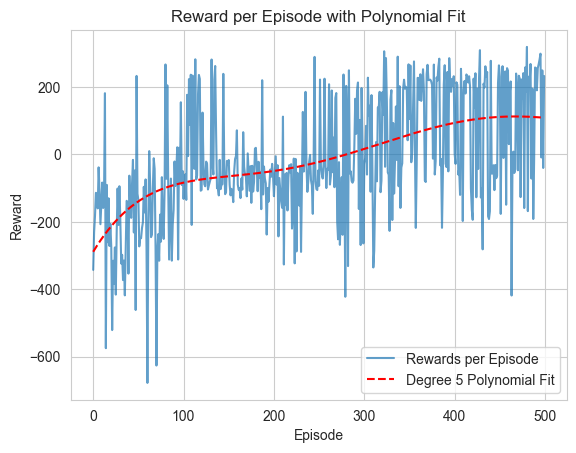

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


sns.set_style("whitegrid")

degree = 5  # Stopień wielomianu
x = np.arange(len(rewards_history))

# Wykres nagród w kolejnych epizodach
sns.lineplot(x=x, y=rewards_history, label="Rewards per Episode", alpha=0.7)

# Obliczenie dopasowania wielomianowego
polynomial_coefficients = np.polyfit(x, rewards_history, degree)
polynomial_fit = np.polyval(polynomial_coefficients, x)

# Wykres dopasowanego wielomianu
sns.lineplot(x=x, y=polynomial_fit, label=f"Degree {degree} Polynomial Fit", color="red", linestyle="--")

# Konfiguracja wykresu
plt.title("Reward per Episode with Polynomial Fit")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.show()

env.close()

## Testowanie modelu

In [56]:
# Initialize device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create the environment
env = gym.make('LunarLander-v2')
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

# Load the trained model
model = DQNetwork(input_size, output_size).to(device)
model.load_state_dict(torch.load('dqn_lunar_lander.pth', map_location=device))
model.eval()

# Test the model
for episode in range(5):
    state = env.reset()
    if isinstance(state, tuple):
        state = state[0]
    total_reward = 0
    done = False
    while not done:
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = model(state_tensor)
        action = torch.argmax(q_values).item()
        next_state, reward, done, info = env.step(action)
        state = next_state
        total_reward += reward
        env.render()
    print(f'Episode {episode + 1}: Total Reward: {total_reward}')
env.close()

Episode 1: Total Reward: 163.96499045094913
Episode 2: Total Reward: 179.47102894626573
Episode 3: Total Reward: 200.6561875908908
Episode 4: Total Reward: 52.56707121964142
Episode 5: Total Reward: -51.275116774381786
